# querying the data lake in a jupyter notebook

## prerequisites

make sure you have `pip install presto-python-client` and `pandas` and `matplotlib` installed.
you may do that via `pip install <name from above>`

In [1]:
import prestodb

In [2]:
conn=prestodb.dbapi.connect(
    host='presto.apps.eu.idealo.com',
    port=443, user='aishwarya.kumar',
    catalog='hive',
    http_scheme='https',
    schema='default',)

In [3]:
conn

## creating a cursor object instance

In [4]:
# create the cursor
cur = conn.cursor()
# cursor objects functions and attributes
[thing for thing in dir(cur) if '_' not in thing]

['arraysize',
 'cancel',
 'close',
 'connection',
 'description',
 'execute',
 'executemany',
 'fetchall',
 'fetchmany',
 'fetchone',
 'genall',
 'rowcount',
 'setinputsizes',
 'setoutputsize',
 'stats']

## exploring the schemas and tables

In [5]:
#schema either in double quotes or without quotes!
cur.execute('''
SHOW TABLES from "dl_inventory_intelligence_prod"
''')
records = cur.fetchall()
list(records)

[['fake_shop'],
 ['feed_quality_layer'],
 ['kpi_product'],
 ['kpi_product_offers'],
 ['kpi_shop'],
 ['merchant_dk'],
 ['pareto_clusters'],
 ['priceapi_processed'],
 ['tidy_category_tree']]

## creating a cursor and querying

query can be highlighted in markdown code blocks (between triple backtics \`\`\`) for better readability
```sql
SELECT * 
FROM "dl_dwh_prod"."so_facts"
WHERE random(1000) = 1
limit 1000
```

## storing the results in a dataframe

In [6]:
import pandas as pd

In [62]:
cur.execute('''
WITH tidy_tree AS (
 SELECT distinct
  category_id,root_category_name,sub_category_name_de,category_name_de
  from dl_inventory_intelligence_prod.tidy_category_tree
  )
  
SELECT
date_format(date(date),'%Y-%m') AS  month_year,
root_category_name,
sub_category_name_de,
sum(pageimpression_oop) as pageimpression_oop,
sum(leadouts_oop)+ sum(checkouts_oop) as LOCO_OOP
FROM "dl_inventory_intelligence_prod"."kpi_product" a 
join tidy_tree t on a.category_id=t.category_id
where site like '%idealo.de%' and date < '2021-09-01'
group by 1,2,3
order by 1,2,3
''') # this was a multiline string.
records = cur.fetchall()
print("Total rows are: ", len(records))

Total rows are:  2503


In [63]:
#getting colnames from description, which is a list of columns with header and their entries
colnames = [col[0] for col in cur.description]
colnames[0:5]
#creating dataframe
df = pd.DataFrame(records, columns=colnames)
df['date'] = pd.to_datetime(df['month_year'])

In [64]:
df.head(5)

,month_year,root_category_name,sub_category_name_de,pageimpression_oop,LOCO_OOP,date
0,2019-07,Auto & Motorrad,Anhänger & Trägersysteme,302769.0,102122.0,2019-07-01
1,2019-07,Auto & Motorrad,Auto Tuning,0.0,0.0,2019-07-01
2,2019-07,Auto & Motorrad,Auto-Werkstattausstattung,39920.0,11170.0,2019-07-01
3,2019-07,Auto & Motorrad,Autopflege,61489.0,12077.0,2019-07-01
4,2019-07,Auto & Motorrad,Autoteil,138994.0,45818.0,2019-07-01


array([[<AxesSubplot:title={'center':'pageimpression_oop'}>]],
      dtype=object)

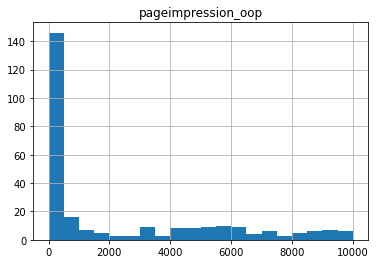

In [65]:
df.hist(column='pageimpression_oop', range=[1,10000],bins=20)

<AxesSubplot:xlabel='month_year'>

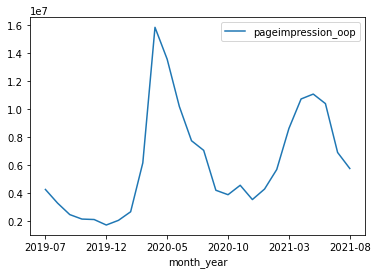

In [66]:
subset=df[(df.sub_category_name_de=="Garten")]
subset.plot( 'month_year' , 'pageimpression_oop' )

In [13]:
sub_cat=df.groupby(['month_year','year','sub_category_name_de'],as_index=False).pageimpression_oop.sum()

root_cat=df.groupby(['month_year','year','root_category_name'],as_index=False).pageimpression_oop.sum()

KeyError: 'year'

In [14]:
subset
subset_1=subset[['date','pageimpression_oop']].set_index("date").to_period("M")
subset_1

,pageimpression_oop
date,
2019-07,4256061.0
2019-08,3278541.0
2019-09,2457913.0
2019-10,2137127.0
2019-11,2105234.0
2019-12,1712171.0
2020-01,2046163.0
2020-02,2660371.0
2020-03,6160898.0


In [285]:
subset.head(5)

,month_year,root_category_name,sub_category_name_de,pageimpression_oop,LOCO_OOP,date
48,2019-07,Gaming & Spielen,Spielekonsole,458835.0,64711.0,2019-07-01
139,2019-08,Gaming & Spielen,Spielekonsole,476015.0,78932.0,2019-08-01
232,2019-09,Gaming & Spielen,Spielekonsole,604978.0,99867.0,2019-09-01
324,2019-10,Gaming & Spielen,Spielekonsole,669441.0,107707.0,2019-10-01
419,2019-11,Gaming & Spielen,Spielekonsole,2628460.0,466487.0,2019-11-01


<ipython-input-15-5d6d131128b7>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


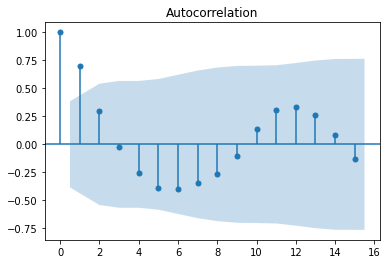

In [15]:

from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot


def parser(x):
    return datetime.strptime(x, '%Y-%m')

#my_series = subset['pageimpression_oop'].squeeze()
#series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
#autocorrelation_plot(my_series)
#pyplot.show()

from statsmodels.graphics.tsaplots import plot_acf
#data["diff"].iloc[0] = 0
plot_acf(subset["pageimpression_oop"])
pyplot.show()

#lag=2


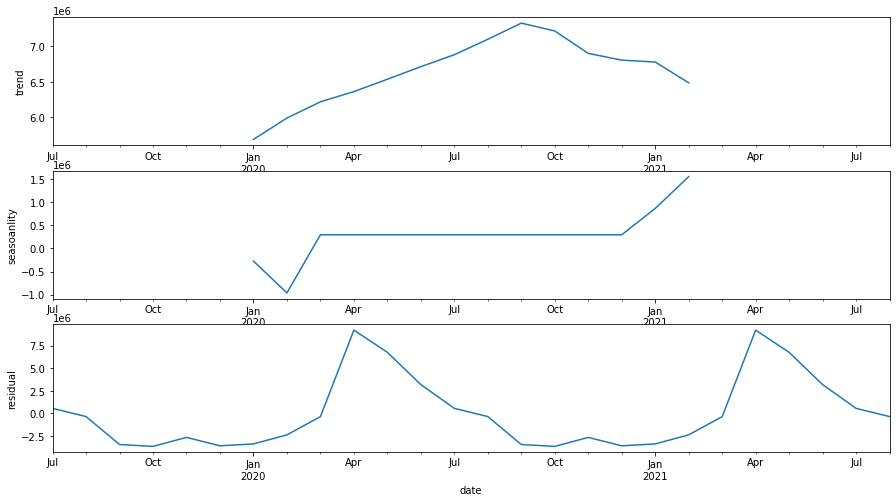

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(subset_1, model = "additive",period = 12)

fig, (ax1,ax2,ax3) = pyplot.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "seasoanlity")
res.seasonal.plot(ax=ax3,ylabel = "residual")
pyplot.show()

In [89]:
from statsmodels.tsa.stattools import adfuller

In [114]:
test_result=adfuller(subset['pageimpression_oop'])

In [133]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(subset['pageimpression_oop'])

ADF Test Statistic : -2.8545018397357995
p-value : 0.050900403692769144
#Lags Used : 1
Number of Observations : 24
weak evidence against null hypothesis,indicating it is non-stationary 


In [134]:
subset['PI First Difference'] = subset['pageimpression_oop'] - subset['pageimpression_oop'].shift(1)
subset['Seasonal First Difference']=subset['pageimpression_oop']-subset['pageimpression_oop'].shift(12)
subset['Seasonal First Difference Difference'] = subset['Seasonal First Difference'] - subset['Seasonal First Difference'].shift(1)
subset.head(20)

<ipython-input-134-235b3d2c6af2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['PI First Difference'] = subset['pageimpression_oop'] - subset['pageimpression_oop'].shift(1)
<ipython-input-134-235b3d2c6af2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Seasonal First Difference']=subset['pageimpression_oop']-subset['pageimpression_oop'].shift(12)
<ipython-input-134-235b3d2c6af2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

,month_year,root_category_name,sub_category_name_de,pageimpression_oop,LOCO_OOP,date,PI First Difference,Seasonal First Difference,Seasonal First Difference Difference
55,2019-07,Haus & Garten,Garten,4256061.0,1270976.0,2019-07-01,NaN,NaN,NaN
146,2019-08,Haus & Garten,Garten,3278541.0,964047.0,2019-08-01,-977520.0,NaN,NaN
239,2019-09,Haus & Garten,Garten,2457913.0,699785.0,2019-09-01,-820628.0,NaN,NaN
331,2019-10,Haus & Garten,Garten,2137127.0,603896.0,2019-10-01,-320786.0,NaN,NaN
426,2019-11,Haus & Garten,Garten,2105234.0,538696.0,2019-11-01,-31893.0,NaN,NaN
520,2019-12,Haus & Garten,Garten,1712171.0,420692.0,2019-12-01,-393063.0,NaN,NaN
616,2020-01,Haus & Garten,Garten,2046163.0,539126.0,2020-01-01,333992.0,NaN,NaN
714,2020-02,Haus & Garten,Garten,2660371.0,715658.0,2020-02-01,614208.0,NaN,NaN
812,2020-03,Haus & Garten,Garten,6160898.0,1703236.0,2020-03-01,3500527.0,NaN,NaN
908,2020-04,Haus & Garten,Garten,15860204.0,4055637.0,2020-04-01,9699306.0,NaN,NaN


In [135]:
# Again testing if data is stationary
adfuller_test(subset['Seasonal First Difference'].dropna())

ADF Test Statistic : 0.6018670092994006
p-value : 0.9876615574413838
#Lags Used : 5
Number of Observations : 8
weak evidence against null hypothesis,indicating it is non-stationary 


<AxesSubplot:xlabel='month_year'>

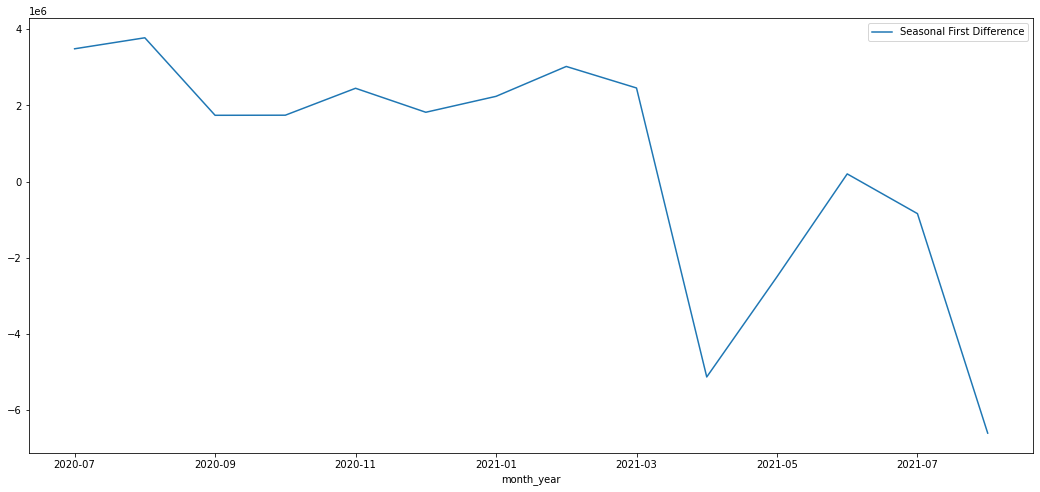

In [136]:

subset.plot( 'month_year' , 'Seasonal First Difference' )

<AxesSubplot:xlabel='date'>

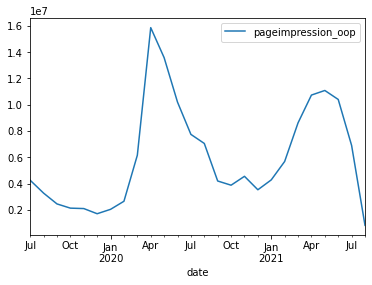

In [17]:
subset_1.plot()

In [146]:
import warnings
import itertools
import numpy as np

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [147]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(subset_1,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:862.7541436761543
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:428.0582298599601
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:430.59923999664693
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:35.661897038338594
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:461.41359571839126
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:429.87902202401375
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:68.95595930507098
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:37.66189691303181
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:812.6942317435103
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:406.1463173810883
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:393.7584939298687
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:473.43000660415214
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:408.019933368902
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:69.1588802597362
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:8.0
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:785.4568514334846
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:390.49593447162584
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - A

/Users/aishwarya.kumar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:424.9011021087075
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:37.45899910965522
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:39.45900150834315
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:783.5204141278007
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:391.8341349898423
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:395.5745074692248
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:8.0
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:423.734060115364
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:393.333647559387
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:39.58303502994859
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:10.0
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:783.763049632714
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:389.323435959872
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:396.3864266951474
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:6.0
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:389.3057770484365
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:391.304779002627
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:6.0
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:8.0
ARIMA(1, 1, 1)x(0, 0, 0, 12)1

In [180]:
import statsmodels.api as sm

mod = sm.tsa.statespace.SARIMAX(subset_1,
                                order=(3,1,1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0267      0.437      2.347      0.019       0.169       1.884
ar.L2         -0.4099      1.296     -0.316      0.752      -2.950       2.130
ar.L3         -0.1992      0.987     -0.202      0.840      -2.133       1.735
ma.L1         -1.0406      0.080    -13.032      0.000      -1.197      -0.884
sigma2      8.023e+12   2.59e-13    3.1e+25      0.000    8.02e+12    8.02e+12


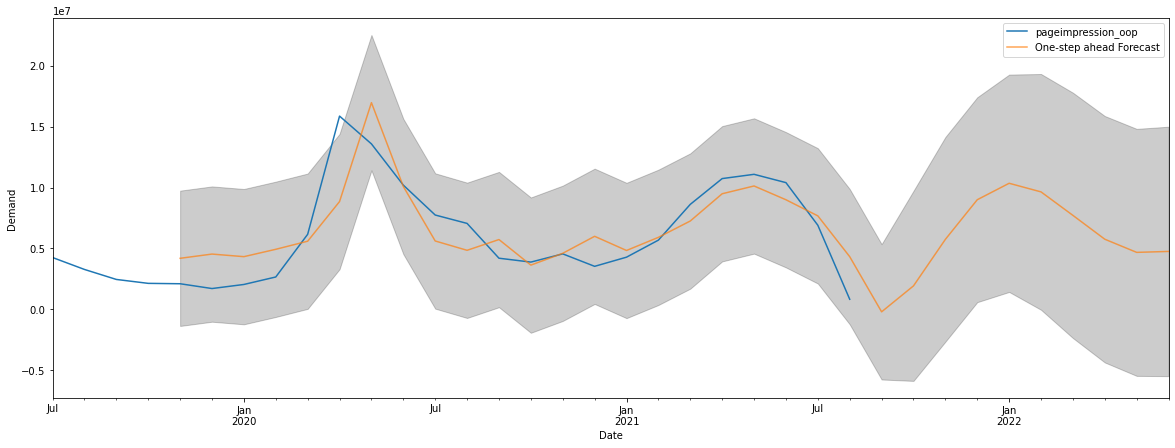

2019-11    4.192798e+06
2019-12    4.539794e+06
2020-01    4.328101e+06
2020-02    4.931183e+06
2020-03    5.595439e+06
2020-04    8.848120e+06
2020-05    1.696419e+07
2020-06    1.008771e+07
2020-07    5.613876e+06
2020-08    4.848794e+06
2020-09    5.731328e+06
2020-10    3.632989e+06
2020-11    4.603600e+06
2020-12    5.997498e+06
2021-01    4.834271e+06
2021-02    5.913222e+06
2021-03    7.253975e+06
2021-04    9.489419e+06
2021-05    1.012724e+07
2021-06    8.996135e+06
2021-07    7.674831e+06
2021-08    4.326192e+06
2021-09   -1.982929e+05
2021-10    1.930442e+06
2021-11    5.747450e+06
2021-12    8.998813e+06
2022-01    1.034850e+07
2022-02    9.641398e+06
2022-03    7.714705e+06
2022-04    5.757631e+06
2022-05    4.678856e+06
2022-06    4.757153e+06
Freq: M, Name: predicted_mean, dtype: float64

In [181]:
pred = results.get_prediction(start=pd.to_datetime('2019-11-01'), end=pd.to_datetime('2022-06-01'),dynamic=False)
pred_ci = pred.conf_int()
ax = subset_1.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(20,7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Demand')
pyplot.legend()
pyplot.show()
pred.predicted_mean

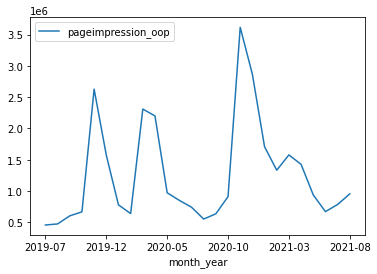

In [90]:
subset=df[(df.sub_category_name_de=="Spielekonsole")]
subset.plot( 'month_year' , 'pageimpression_oop' )
y=subset[['date','pageimpression_oop']].set_index("date").to_period("M")

In [193]:
# Split Train & Test Data
y_train=y[:len(y)-1]
y_test=y[len(y)-1:]


<AxesSubplot:xlabel='date'>

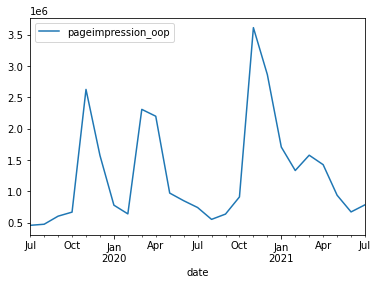

In [194]:
y_train.plot()

<AxesSubplot:xlabel='date'>

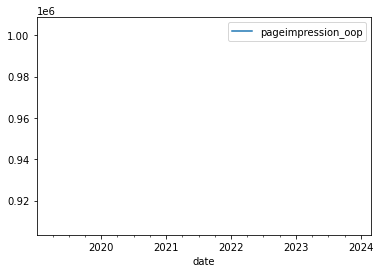

In [195]:
y_test.plot()

In [284]:
# testing for stationarity of the data
from statsmodels.tsa.stattools import adfuller
from math import log
result = adfuller(y_train['pageimpression_oop'])
print('ADF Statistic for Spielekonsole: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value)) # data is stationary

ADF Statistic for Spielekonsole: -3.718675
p-value: 0.003858
Critical Values:
	1%: -3.753
	5%: -2.998
	10%: -2.639


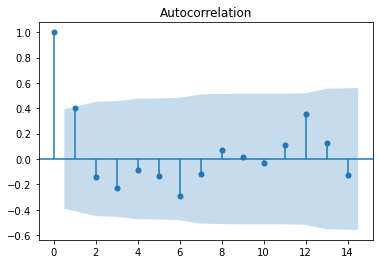

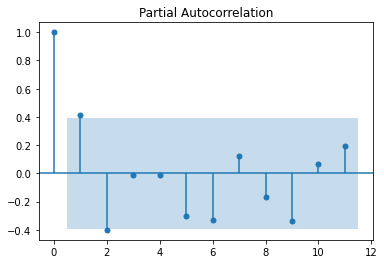

In [197]:
#plotting acf and pacf
from pandas import datetime
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm


def parser(x):
    return datetime.strptime(x, '%Y-%m')

#my_series = subset['pageimpression_oop'].squeeze()
#series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
#autocorrelation_plot(my_series)
#pyplot.show()

from statsmodels.graphics.tsaplots import plot_acf
#data["diff"].iloc[0] = 0
plot_acf(y_train["pageimpression_oop"])
sm.graphics.tsa.plot_pacf(y_train["pageimpression_oop"].squeeze(), lags=11)
pyplot.show()

#lag=2

In [198]:
import itertools
import warnings
warnings.filterwarnings("ignore")

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

                print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))
    
sarima_grid_search(y_train,12)    

SARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:754.3859663314195
SARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:360.17615062041693
SARIMA(0, 0, 0)x(0, 0, 2, 12) - AIC:6.0
SARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:361.61715410200964
SARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:4.0
SARIMA(0, 0, 0)x(0, 1, 2, 12) - AIC:6.0
SARIMA(0, 0, 0)x(0, 2, 0, 12) - AIC:2.0
SARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:387.70928372077015
SARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:362.1910492098465
SARIMA(0, 0, 0)x(1, 0, 2, 12) - AIC:8.0
SARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:32.44403748254847
SARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:6.0
SARIMA(0, 0, 0)x(1, 1, 2, 12) - AIC:8.0
SARIMA(0, 0, 0)x(2, 0, 0, 12) - AIC:35.0977901940781
SARIMA(0, 0, 0)x(2, 0, 1, 12) - AIC:37.05856989804961
SARIMA(0, 0, 0)x(2, 0, 2, 12) - AIC:10.0
SARIMA(0, 0, 0)x(2, 1, 0, 12) - AIC:6.0
SARIMA(0, 0, 0)x(2, 1, 1, 12) - AIC:8.0
SARIMA(0, 0, 0)x(2, 1, 2, 12) - AIC:10.0
SARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:712.0622031967639
SARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:339.41623544455774
SARIMA(0, 0, 1)

SARIMA(0, 2, 1)x(2, 2, 2, 12) - AIC:12.0
SARIMA(0, 2, 2)x(0, 0, 0, 12) - AIC:613.9840424013372
SARIMA(0, 2, 2)x(0, 0, 1, 12) - AIC:245.5214234547265
SARIMA(0, 2, 2)x(0, 0, 2, 12) - AIC:10.0
SARIMA(0, 2, 2)x(0, 1, 0, 12) - AIC:246.22170329323026
SARIMA(0, 2, 2)x(0, 1, 1, 12) - AIC:8.0
SARIMA(0, 2, 2)x(0, 1, 2, 12) - AIC:10.0
SARIMA(0, 2, 2)x(0, 2, 0, 12) - AIC:6.0
SARIMA(0, 2, 2)x(0, 2, 1, 12) - AIC:8.0
SARIMA(0, 2, 2)x(0, 2, 2, 12) - AIC:10.0
SARIMA(0, 2, 2)x(1, 0, 0, 12) - AIC:335.6311911963901
SARIMA(0, 2, 2)x(1, 0, 1, 12) - AIC:247.02269822946784
SARIMA(0, 2, 2)x(1, 0, 2, 12) - AIC:12.0
SARIMA(0, 2, 2)x(1, 1, 0, 12) - AIC:8.0
SARIMA(0, 2, 2)x(1, 1, 1, 12) - AIC:10.0
SARIMA(0, 2, 2)x(1, 1, 2, 12) - AIC:12.0
SARIMA(0, 2, 2)x(1, 2, 0, 12) - AIC:8.0
SARIMA(0, 2, 2)x(1, 2, 1, 12) - AIC:10.0
SARIMA(0, 2, 2)x(1, 2, 2, 12) - AIC:12.0
SARIMA(0, 2, 2)x(2, 0, 0, 12) - AIC:10.0
SARIMA(0, 2, 2)x(2, 0, 1, 12) - AIC:12.0
SARIMA(0, 2, 2)x(2, 0, 2, 12) - AIC:14.0
SARIMA(0, 2, 2)x(2, 1, 0, 12) - AIC:

SARIMA(1, 2, 0)x(2, 2, 1, 12) - AIC:10.0
SARIMA(1, 2, 0)x(2, 2, 2, 12) - AIC:12.0
SARIMA(1, 2, 1)x(0, 0, 0, 12) - AIC:646.6156838781983
SARIMA(1, 2, 1)x(0, 0, 1, 12) - AIC:275.1397786334363
SARIMA(1, 2, 1)x(0, 0, 2, 12) - AIC:10.0
SARIMA(1, 2, 1)x(0, 1, 0, 12) - AIC:272.95323022574496
SARIMA(1, 2, 1)x(0, 1, 1, 12) - AIC:8.0
SARIMA(1, 2, 1)x(0, 1, 2, 12) - AIC:10.0
SARIMA(1, 2, 1)x(0, 2, 0, 12) - AIC:6.0
SARIMA(1, 2, 1)x(0, 2, 1, 12) - AIC:8.0
SARIMA(1, 2, 1)x(0, 2, 2, 12) - AIC:10.0
SARIMA(1, 2, 1)x(1, 0, 0, 12) - AIC:304.5828849415242
SARIMA(1, 2, 1)x(1, 0, 1, 12) - AIC:276.90236249436106
SARIMA(1, 2, 1)x(1, 0, 2, 12) - AIC:12.0
SARIMA(1, 2, 1)x(1, 1, 0, 12) - AIC:8.0
SARIMA(1, 2, 1)x(1, 1, 1, 12) - AIC:10.0
SARIMA(1, 2, 1)x(1, 1, 2, 12) - AIC:12.0
SARIMA(1, 2, 1)x(1, 2, 0, 12) - AIC:8.0
SARIMA(1, 2, 1)x(1, 2, 1, 12) - AIC:10.0
SARIMA(1, 2, 1)x(1, 2, 2, 12) - AIC:12.0
SARIMA(1, 2, 1)x(2, 0, 0, 12) - AIC:10.0
SARIMA(1, 2, 1)x(2, 0, 1, 12) - AIC:12.0
SARIMA(1, 2, 1)x(2, 0, 2, 12) - AIC:

SARIMA(2, 2, 0)x(0, 0, 1, 12) - AIC:309.34386685652623
SARIMA(2, 2, 0)x(0, 0, 2, 12) - AIC:10.0
SARIMA(2, 2, 0)x(0, 1, 0, 12) - AIC:274.4163575087008
SARIMA(2, 2, 0)x(0, 1, 1, 12) - AIC:8.0
SARIMA(2, 2, 0)x(0, 1, 2, 12) - AIC:10.0
SARIMA(2, 2, 0)x(0, 2, 0, 12) - AIC:6.0
SARIMA(2, 2, 0)x(0, 2, 1, 12) - AIC:8.0
SARIMA(2, 2, 0)x(0, 2, 2, 12) - AIC:10.0
SARIMA(2, 2, 0)x(1, 0, 0, 12) - AIC:279.4214176417333
SARIMA(2, 2, 0)x(1, 0, 1, 12) - AIC:281.4330318225911
SARIMA(2, 2, 0)x(1, 0, 2, 12) - AIC:12.0
SARIMA(2, 2, 0)x(1, 1, 0, 12) - AIC:8.0
SARIMA(2, 2, 0)x(1, 1, 1, 12) - AIC:10.0
SARIMA(2, 2, 0)x(1, 1, 2, 12) - AIC:12.0
SARIMA(2, 2, 0)x(1, 2, 0, 12) - AIC:8.0
SARIMA(2, 2, 0)x(1, 2, 1, 12) - AIC:10.0
SARIMA(2, 2, 0)x(1, 2, 2, 12) - AIC:12.0
SARIMA(2, 2, 0)x(2, 0, 0, 12) - AIC:10.0
SARIMA(2, 2, 0)x(2, 0, 1, 12) - AIC:12.0
SARIMA(2, 2, 0)x(2, 0, 2, 12) - AIC:14.0
SARIMA(2, 2, 0)x(2, 1, 0, 12) - AIC:10.0
SARIMA(2, 2, 0)x(2, 1, 1, 12) - AIC:12.0
SARIMA(2, 2, 0)x(2, 1, 2, 12) - AIC:14.0
SARIMA(2,

In [208]:
import statsmodels.api as sm
#SARIMA(1, 0, 0)x(0, 1, 1, 12) - AIC:6.0
#SARIMA(1, 0, 0)x(0, 2, 0, 12) - AIC:4.0
#SARIMA(0, 0, 0)x(0, 2, 0, 12) - AIC:2.0
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order=(1,0,0),
                                seasonal_order=(1, 1, 1, 12),
                                #enforce_stationarity=False,
                                #enforce_invertibility=False,
                                freq='M')
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6964      0.264      2.642      0.008       0.180       1.213
ar.S.L12      -0.5227     18.335     -0.029      0.977     -36.458      35.412
ma.S.L12       0.3991     18.809      0.021      0.983     -36.466      37.264
sigma2       2.45e+11   4.78e-09   5.13e+19      0.000    2.45e+11    2.45e+11


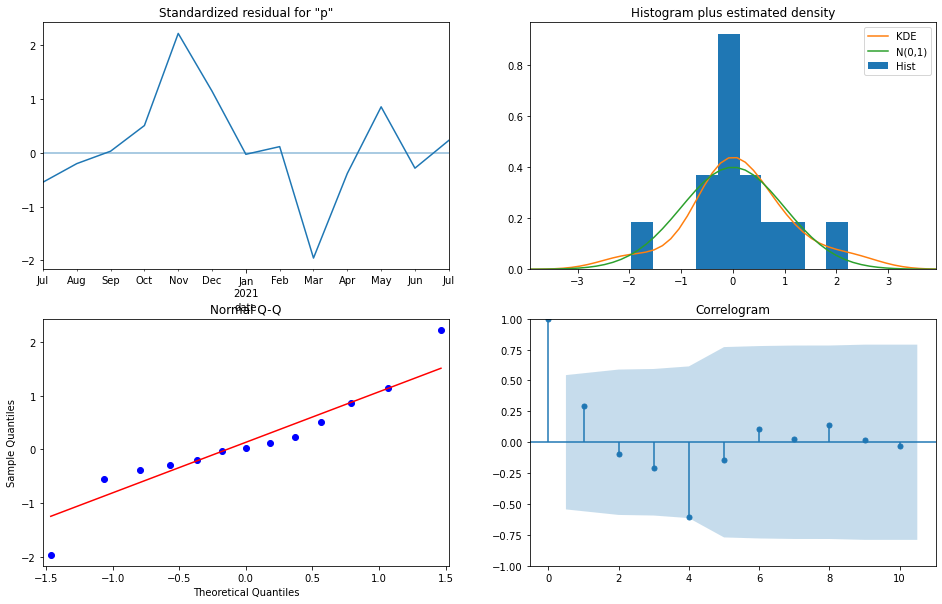

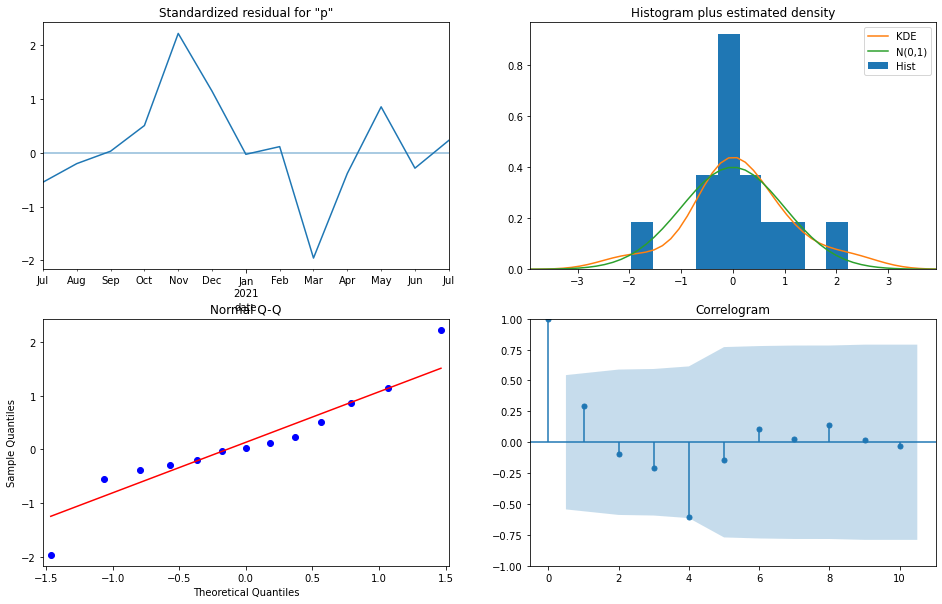

In [209]:
results.plot_diagnostics(figsize=(16,10))

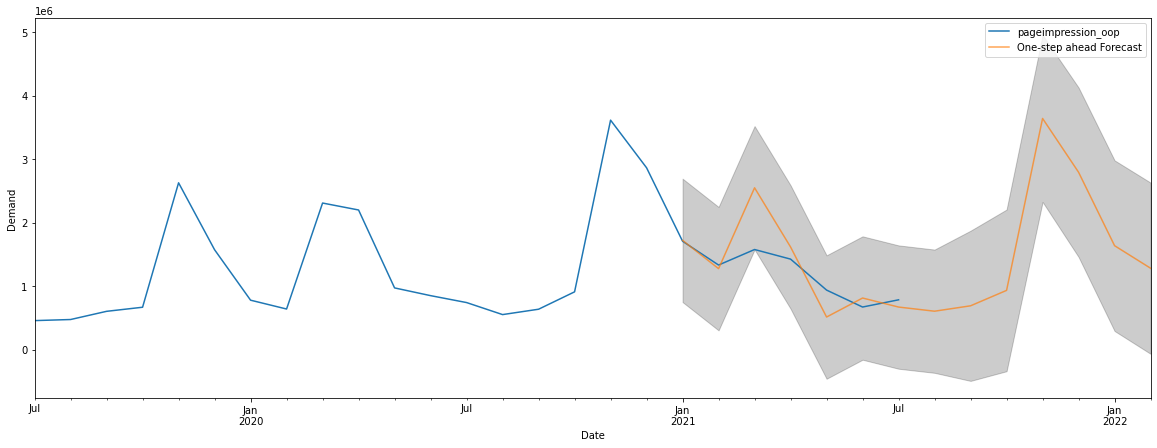

2021-01    1.722150e+06
2021-02    1.276832e+06
2021-03    2.549666e+06
2021-04    1.617529e+06
2021-05    5.152259e+05
2021-06    8.144506e+05
2021-07    6.722085e+05
2021-08    6.069084e+05
2021-09    6.920175e+05
2021-10    9.347718e+05
2021-11    3.641754e+06
2021-12    2.794592e+06
2022-01    1.638501e+06
2022-02    1.283653e+06
Freq: M, Name: predicted_mean, dtype: float64

In [212]:
pred = results.get_prediction(start=pd.to_datetime('2021-01-01'), end=pd.to_datetime('2022-02-01'),dynamic=False)
pred_ci = pred.conf_int()
ax = y_train.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(20,7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Demand')
pyplot.legend()
pyplot.show()
pred.predicted_mean

In [286]:
#errors in prediction
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
y_forecasted = pred.predicted_mean.to_frame()
y_truth = y_test['2021-05-01':]
y_forecasted = y_forecasted['2021-05-01':].rename(columns={"predicted_mean": "value"})
y_forecasted=y_forecasted[0:1].round()
y_truth = y_truth.rename(columns={"pageimpression_oop": "value"})
mse=mean_squared_error(y_truth['value'],y_forecasted['value'])
mpe=mean_absolute_percentage_error(y_truth['value'],y_forecasted['value'])
mse2 = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))
#print('The Mean Squared Error is {}'.format(round(mpe, 2)))
print('The Root Mean Percentage Squared Error is {}'.format(mpe,2))

The Mean Squared Error is 194314337721.0
The Root Mean Squared Error is 440811.0
The Root Mean Percentage Squared Error is 0.4610815271793874


In [264]:
type(y_forecasted['value'])

pandas.core.series.Series

In [257]:
y_forecasted[0:1].round()

,value
2021-08,606908.0


NameError: name 'plt' is not defined

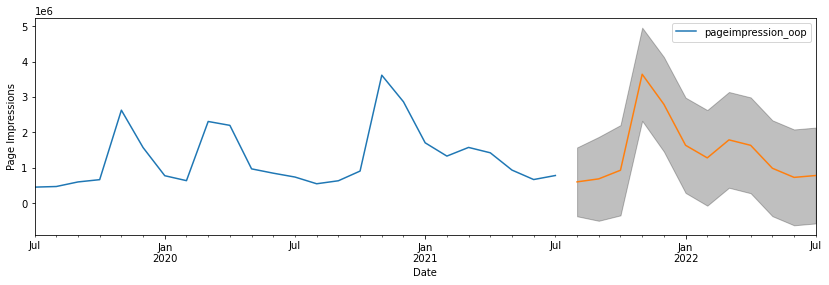

In [215]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = y_train.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Page Impressions')
plt.legend()
plt.show()

In [217]:
y_forecasted = pred.predicted_mean
y_forecasted.head(12)

2021-01    1.722150e+06
2021-02    1.276832e+06
2021-03    2.549666e+06
2021-04    1.617529e+06
2021-05    5.152259e+05
2021-06    8.144506e+05
2021-07    6.722085e+05
2021-08    6.069084e+05
2021-09    6.920175e+05
2021-10    9.347718e+05
2021-11    3.641754e+06
2021-12    2.794592e+06
Freq: M, Name: predicted_mean, dtype: float64

In [218]:
y_truth.head(12)

,value
date,
2021-01,1708361.0
2021-02,1333806.0
2021-03,1578207.0
2021-04,1427040.0
2021-05,939391.0
2021-06,672597.0
2021-07,786272.0


In [219]:
pred_ci.head(24)

,lower pageimpression_oop,upper pageimpression_oop
2021-08,-3.634146e+05,1.577231e+06
2021-09,-4.904045e+05,1.874439e+06
2021-10,-3.378429e+05,2.207386e+06
2021-11,2.327628e+06,4.955881e+06
2021-12,1.460800e+06,4.128383e+06
2022-01,2.952780e+05,2.981725e+06
2022-02,-6.411745e+04,2.631424e+06
2022-03,4.412855e+05,3.141213e+06
2022-04,2.865832e+05,2.988609e+06
2022-05,-3.602858e+05,2.342703e+06


In [221]:
forecast = pred_uc.predicted_mean
forecast.head(12)
forecast.round()

2021-08     606908.0
2021-09     692017.0
2021-10     934772.0
2021-11    3641754.0
2021-12    2794592.0
2022-01    1638501.0
2022-02    1283653.0
2022-03    1791249.0
2022-04    1637596.0
2022-05     991208.0
2022-06     733546.0
2022-07     786240.0
Freq: M, Name: predicted_mean, dtype: float64